<a href="https://colab.research.google.com/github/rahiakela/hands-on-unsupervised-learning-using-python/blob/main/3-dimensionality-reduction/2_linear_dimensionality_reduction_using_linear_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Dimensionality Reduction using Linear Projection

The major challenges in building successful applied machine learning solutions: **the curse of dimensionality**. Unsupervised learning has a great counter—**dimensionality reduction**.

There are two major branches of dimensionality reduction.

- **Linear projection**: which involves linearly projecting data from a high
dimensional space to a low-dimensional space. This includes techniques such as
principal component analysis, singular value decomposition, and random
projection.

- **Manifold learning**: which is also referred to as nonlinear
dimensionality reduction. This involves techniques such as isomap, which learns the curved distance (also called the geodesic distance) between points rather
than the Euclidean distance. 

- **Other techniques**: include multidimensional scaling
(MDS), locally linear embedding (LLE), t-distributed stochastic neighbor
embedding (t-SNE), dictionary learning, random trees embedding, and
independent component analysis.

Dimensionality reduction helps counteract one of the most commonly occurring problems in machine learning—the curse of dimensionality—in which algorithms cannot effectively and efficiently train on the data because of the sheer size of the feature space.

Dimensionality reduction algorithms project high-dimensional data to a lowdimensional space, retaining as much of the salient information as possible while removing redundant information. Once the data is in the low-dimensional space, machine learning algorithms are able to identify interesting patterns more effectively and efficiently because a lot of the noise has been reduced.

Sometimes, dimensionality reduction is the goal itself—for example, to build
anomaly detection systems.

Other times, dimensionality reduction is not an end in itself but rather a means to another end. 

For example, dimensionality reduction is commonly a part of the
machine learning pipeline to help solve large-scale, computationally expensive
problems involving images, video, speech, and text.


## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, pickle, gzip
import datetime

'''Data Prep'''
from sklearn import preprocessing as pp 
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD

# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
!wget -q https://github.com/aapatel09/handson-unsupervised-learning/raw/master/datasets/mnist_data/mnist.pkl.gz

## Data acquisition and exploration

We will work with a simple computer vision dataset: the MNIST (Mixed National Institute of Standards and Technology) database of handwritten digits, one of the best known datasets in machine learning.

This dataset consists of 28x28 pixel images of handwritten digits. Every single
data point (i.e., every image) can be conveyed as an array of numbers, where
each number describes how dark each pixel is. In other words, a 28x28 array of
numbers corresponds to a 28x28 pixel image.

To make this simpler, we can flatten each array into a 28x28, or 784,
dimensional vector. Each component of the vector is a float between zero and
one—representing the intensity of each pixel in the image. Zero stands for black;
one stands for white. The labels are numbers between zero and nine, and indicate
which digit the image represents.

Let’s now load the MNIST datasets:

In [2]:
# Load the datasets
f = gzip.open("mnist.pkl.gz", "rb")
train_set, validation_set, test_set = pickle.load(f, encoding="latin1")
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

Let’s verify the shape of the datasets to make sure they loaded properly:

In [3]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


Let’s convert the numpy arrays into Pandas DataFrames so they are easier to
explore and work with:

In [4]:
# Create Pandas DataFrames from the datasets
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation) + len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test , index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

Let’s generate a summary view of the data:

In [5]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,0.000037,0.000017,7.031250e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.000004,0.000044,0.000108,0.000155,0.000210,0.000380,0.000570,...,0.013975,0.010081,0.006603,0.003967,0.002168,0.001039,0.000333,0.000067,2.343750e-07,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000067,0.000173,0.000377,0.000501,0.000709,0.001159,0.001440,0.001910,0.002044,0.002479,0.002171,0.001725,0.001215,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002034,0.005825,0.003773,1.572223e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000280,0.000833,0.004514,0.008921,0.010814,0.012095,0.016715,0.020658,...,0.102319,0.086386,0.070681,0.054545,0.041041,0.027224,0.014586,0.005078,5.240772e-05,0.001031,0.0,0.0,0.0,0.0,0.0,0.0,0.001872,0.007228,0.010340,0.016519,0.019057,0.023204,0.027897,0.032083,0.037493,0.037788,0.042872,0.039894,0.034695,0.029488,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [7]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

Let’s define a function to view the image along with its label:

In [8]:
def view_digit(example):
  label = y_train.loc[example]
  image = X_train.loc[example,:].values.reshape([28,28])
  plt.title('Example: %d  Label: %d' % (example, label))
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.show()

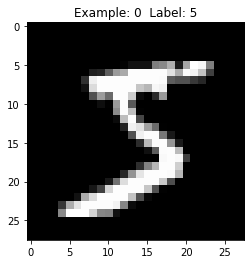

In [9]:
# View the first digit
view_digit(0)

## Principal Component Analysis

We will explore several versions of PCA, including:

- Standard PCA
- Incremental PCA 
- Sparse PCA 
- Kernel PCA

### Standard PCA

Let’s start with standard PCA, one of the most common linear dimensionality
reduction techniques. In PCA, the algorithm finds a low-dimensional
representation of the data while retaining as much of the variation (i.e., salient information) as possible.

PCA does this by addressing the correlation among features. If the correlation is very high among a subset of the features, PCA will attempt to combine the
highly correlated features and represent this data with a smaller number of
linearly uncorrelated features. The algorithm keeps performing this correlation
reduction, finding the directions of maximum variance in the original highdimensional data and projecting them onto a smaller dimensional space. These
newly derived components are known as principal components.

With these components, it is possible to reconstruct the original features—not
exactly but generally close enough. The PCA algorithm actively attempts to
minimize the reconstruction error during its search for the optimal components.

In our MNIST example, the original feature space has 784 dimensions, known as
d dimensions. PCA will project the data onto a smaller subspace of k dimensions
(where k < d) while retaining as much of the salient information as possible.
These k dimensions are known as the principal components.

The number of meaningful principal components we are left with is considerably
smaller than the number of dimensions in the original dataset. We lose some of
the variance (i.e., information) by moving to this low-dimensional space, but the underlying structure of the data is easier to identify, allowing us to perform tasks like anomaly detection and clustering more effectively and efficiently.

Moreover, by reducing the dimensionality of the data, PCA will reduce the size
of the data, improving the performance of machine learning algorithms further
along in the machine learning pipeline (for example, for tasks such as image
classification).

>**NOTE**: It is essential to perform feature scaling before running PCA. PCA is very sensitive to the relative ranges of the original features. Generally we must scale the data to make sure the features are in the same relative range. However, for our MNIST digits dataset, the features are already scaled to a range of zero to one, so we can skip this step.

**PCA in Practice**

Let’s apply PCA to the MNIST digits dataset and see how well PCA captures the most salient information about the digits as its projects the data from the original 784-dimensional space to a lower dimensional space.

Let’s set the hyperparameters for the PCA algorithm:

In [6]:
n_components = 784
whiten = False
random_state = 2018

In [7]:
pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

**Apply PCA**

We will set the number of principal components to the original number of
dimensions (i.e., 784). Then, PCA will capture the salient information from the
original dimensions and start generating principal components. Once these components are generated, we will determine how many principal components
we need to effectively capture most of the variance/information from the original feature set.

Let’s fit and transform our training data, generating these principal components:

In [8]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

**Evaluate PCA**

Because we have not reduced the dimensionality at all (we’ve just transformed
the data) the variance/information of the original data captured by the 784
principal components should be 100%:

In [9]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  1.0000000252108534


However, it is important to note that the importance of the 784 principal
components varies quite a bit. The importance of the first X principal
components are summarized here:

In [10]:
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents .T

print("Variance Captured by First 10 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:9].sum(axis=1).values)
print("Variance Captured by First 20 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:19].sum(axis=1).values)
print("Variance Captured by First 50 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:49].sum(axis=1).values)
print("Variance Captured by First 100 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:99].sum(axis=1).values)
print("Variance Captured by First 200 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:199].sum(axis=1).values)
print("Variance Captured by First 300 Principal Components: ", importanceOfPrincipalComponents.loc[:, 0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.48876244]
Variance Captured by First 20 Principal Components:  [0.6439803]
Variance Captured by First 50 Principal Components:  [0.824861]
Variance Captured by First 100 Principal Components:  [0.91465855]
Variance Captured by First 200 Principal Components:  [0.96650076]
Variance Captured by First 300 Principal Components:  [0.9862489]


The first 10 components in total capture approximately 50% of the variance, the
first one hundred components over 90%, and the first three hundred components
almost 99% of the variance; the information in the rest of the principal
components is of negligible value.


We can also plot the importance of each principal component, ranked from the
first principal component to the last.

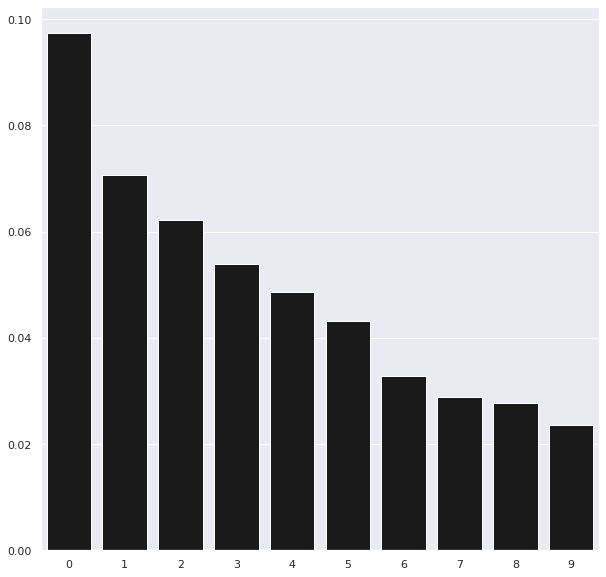

In [11]:
# View percentage captured by first X components
sns.set(rc={"figure.figsize": (10, 10)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:, 0:9], color="k")

The power of PCA should be more apparent now. With just the first two hundred
principal components (far fewer than the original 784 dimensions), we capture
over 96% of the variance/information.

PCA allows us to reduce the dimensionality of the original data substantially
while retaining most of the salient information. On the PCA-reduced feature set,
other machine learning algorithms—downstream in the machine learning
pipeline—will have an easier time separating the data points in space (to perform tasks such as anomaly detection and clustering) and will require fewer
computational resources.

**Visualize the separation of points in space**

To demonstrate the power of PCA to efficiently and compactly capture the
variance/information in data, let’s plot the observations in two dimensions.
Specifically, we will display a scatterplot of the first and second principal
components and mark the observations by the true label.

In [12]:
def scatterPlot(xDF, yDF, algoName):
  tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
  tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
  tempDF.columns = ["First Vector", "Second Vector", "Label"]
  sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
  ax = plt.gca()
  ax.set_title("Separation of Observations using "+algoName)

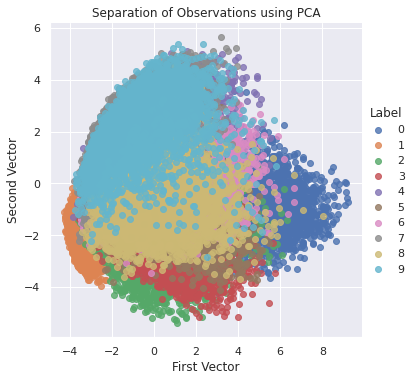

In [13]:
scatterPlot(X_train_PCA, y_train, "PCA")

PCA does a good job of separating the points in space such that similar points are generally closer to each other than they are to other, less similar points. In other words, images of the same digit are closer to each other than they are to images of other digits.

**PCA accomplishes this without using any labels whatsoever. This demonstrates
the power of unsupervised learning to capture the underlying structure of data,
helping discover hidden patterns in the absence of labels.**

If we run the same two-dimensional scatterplot using two of the most important
features from the original 784 feature set—determined by training a supervised
learning model—the separation is poor, at best.

Text(0.5, 1.0, 'Separation of Observations Using Original Feature Set')

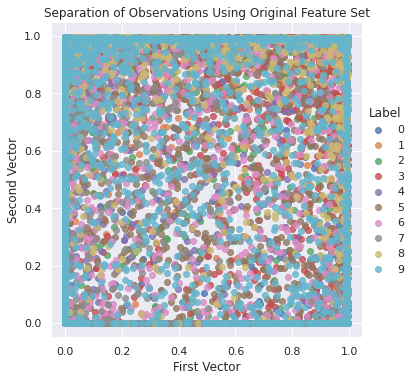

In [14]:
# View two random dimensions
X_train_scatter = pd.DataFrame(data=X_train.loc[:, [350, 406]], index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter, y_train), axis=1, join="inner")

X_train_scatter.columns = ["First Vector", "Second Vector", "Label"]
sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=X_train_scatter, fit_reg=False)
ax = plt.gca()
ax.set_title("Separation of Observations Using Original Feature Set")

### Incremental PCA

For datasets that are very large and cannot fit in memory, we can perform PCA
incrementally in small batches, where each batch is able to fit in memory. The
batch size can be either set manually or determined automatically. This batchbased form of PCA is known as incremental PCA.

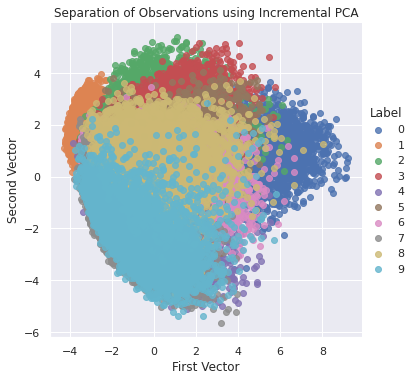

In [19]:
n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components, batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(data=X_train_incrementalPCA, index=train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

The resulting principal components of PCA and incremental PCA are generally pretty similar.

### Sparse PCA

The normal PCA algorithm searches for linear combinations in all the input
variables, reducing the original feature space as densely as possible. But for
some machine learning problems, some degree of sparsity may be preferred. 

A version of PCA that retains some degree of sparsity—controlled by a
hyperparameter called alpha—is known as sparse PCA. The sparse PCA
algorithm searches for linear combinations in just some of the input variables,
reducing the original feature space to some degree but not as compactly as
normal PCA.

Because this algorithm trains a bit more slowly than normal PCA, we will train
on just the first 10,000 examples in our training set (out of the total 50,000
examples).



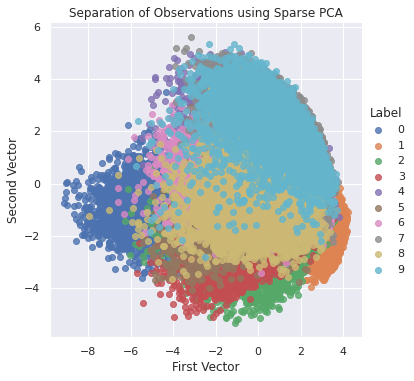

In [20]:
n_components = 100
alpha = 0.0001
random_state = 2020
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)
sparsePCA.fit(X_train.loc[:1000, :])

X_train_sparsePCA = sparsePCA.fit_transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

Notice that this scatterplot looks different from that of the normal PCA, as
expected. Normal and sparse PCA generate principal components differently,
and the separation of points is somewhat different, too.

###Kernel PCA

Normal PCA, incremental PCA, and sparse PCA linearly project the original
data onto a lower dimensional space, but there is also a nonlinear form of PCA
known as kernel PCA, which runs a similarity function over pairs of original
data points in order to perform nonlinear dimensionality reduction.

By learning this similarity function (known as the kernel method), kernel PCA
maps the implicit feature space where the majority of data points lie and creates this implicit feature space in a much smaller number of dimensions than the dimensions in the original feature set. This method is especially effective when the original feature set is not linearly separable.

For the kernel PCA algorithm, we need to set the number of components we
desire, the type of kernel, and the kernel coefficient, which is known as the
gamma. The most popular kernel is the radial basis function kernel, more
commonly referred to as the RBF kernel.

In [ ]:
n_components = 100
kernel = "rbf"
gamma = None
random_state = 2020
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, random_state=random_state, n_jobs=n_jobs)
kernelPCA.fit(X_train.loc[:1000, :])

X_train_kernelPCA = kernelPCA.fit_transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

The two-dimensional scatterplot of the kernel PCA is nearly identical to the one
of the linear PCA for our MNIST digits dataset.Learning the RBF
kernel does not improve the dimensionality reduction.

### Conclusions

Not only does PCA help separate data so that we can discover hidden patterns more readily, it also helps reduce the size of the feature set, making it less costly—both in time and in computational resources—to train machine learning models.

With the MNIST dataset, the reduction in training time will be modest at best since the dataset is very small—we have only 784 features and 50,000 observations. But if the dataset were millions of features and billions of observations, dimensionality reduction would dramatically reduce the training time of the machine learning algorithms further along in the machine
learning pipeline.

Lastly, PCA usually throws away some of the information available in the original feature set but does so wisely, capturing the most important elements and tossing the less valuable ones. A model that is trained on a PCA-reduced feature set may not perform quite as well in terms of accuracy as a model that is trained on the full feature set, but both the training and prediction
times will be much faster. This is one of the important trade-offs you must consider when choosing whether to use dimensionality reduction in your machine learning product.

##Singular Value Decomposition

Another approach to learning the underlying structure of the data is to reduce the rank of the original matrix of features to a smaller rank such that the original matrix can be recreated using a linear combination of some of the vectors in the smaller rank matrix. This is known as singular value decomposition (SVD).

To generate the smaller rank matrix, SVD keeps the vectors of the original
matrix that have the most information (i.e., the highest singular value). The
smaller rank matrix captures the most important elements of the original feature
space.

This is very similar to PCA. PCA, which uses the eigen-decomposition of the
covariance matrix to perform dimensionality reduction. SVD uses singular value
decomposition, as its name implies. In fact, PCA involves the use of SVD in its
calculation.

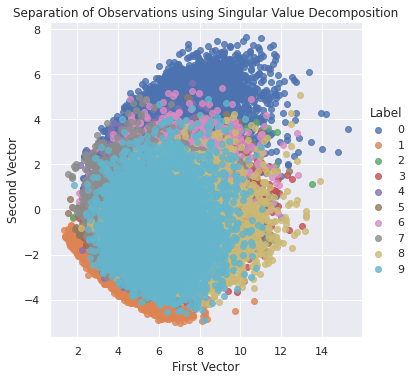

In [16]:
n_components = 200
algorithm = "randomized"
n_iter = 5
random_state = 2020

svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)

scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")

##Random Projection

Another linear dimensionality reduction technique is random projection, which
relies on the Johnson–Lindenstrauss lemma. According to the Johnson–
Lindenstrauss lemma, points in a high-dimensional space can be embedded into a much lower-dimensional space so that distances between the points are nearly
preserved. In other words, even as we move from high-dimensional space to
low-dimensional space, the relevant structure of the original feature set is
preserved.

There are two versions of random projection—
- Gaussian random projection: the standard version
- Sparse random projection: the sparse version

###Gaussian Random Projection

For Gaussian random projection, we can either specify the number of
components we would like to have in the reduced feature space, or we can set
the hyperparameter eps. The eps controls the quality of the embedding according
to the Johnson–Lindenstrauss lemma, where smaller values generate a higher
number of dimensions.

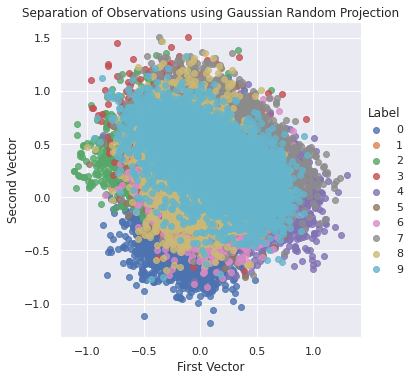

In [17]:
n_components = "auto"
eps = 0.5
random_state = 2020

grp = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)

X_train_GRP = grp.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)

X_validation_GRP = grp.transform(X_validation)
X_validation_GRP = pd.DataFrame(data=X_validation_GRP, index=validation_index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

Although it is a form of linear projection like PCA, random projection is an
entirely different family of dimensionality reduction. Thus the random projection scatterplot looks very different from the scatterplots of normal PCA, incremental PCA, sparse PCA, and kernel PCA.

###Sparse Random Projection

Just as there is a sparse version of PCA, there is a sparse version of random
projection known as sparse random projection. It retains some degree of sparsity
in the transformed feature set and is generally much more efficient, transforming the original data into the reduced space much faster than normal Gaussian random projection.

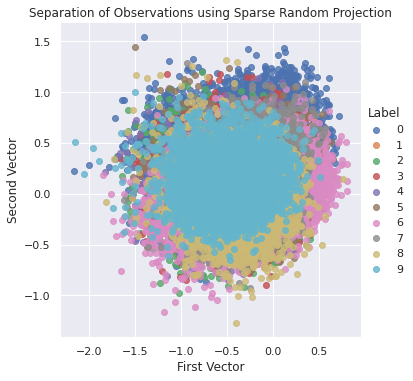

In [18]:
n_components = "auto"
density = "auto"
eps = 0.5
dense_output = False
random_state = 2020

srp = SparseRandomProjection(n_components=n_components, eps=eps, density=density, dense_output=dense_output, random_state=random_state)

X_train_SRP = srp.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)

X_validation_SRP = srp.transform(X_validation)
X_validation_SRP = pd.DataFrame(data=X_validation_SRP, index=validation_index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")